# Overview

**Monte Carlo Method** - ***by Felicity Bui***





*   Monte Carlo (MC) models the probability of different outcomes in a process that cannot easily be predicted due to the involvement of random variables.
* Can be used for risk management, option pricing, and simulating financial scenarios.
* MC is performed on 5 big Tech companies - Apple Inc., Microsoft Coporation, Amazon.com Inc., Alphabet Inc., and Meta Platforms, Inc..








# Portfolio generation

In [ ]:
#!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
#import data
def get_data(stocks, start, end):
  stock_data = yf.download(stocks, start=start_date, end=end_date)
  stock_data = stock_data['Close']
  returns = stock_data.pct_change()
  mean_return = returns.mean()
  cov_matrix = returns.cov()
  return mean_return, cov_matrix


tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG','META']
stocks = [stock for stock in tickers] #add .AX if Australian stocks
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365) #important for covariance matrix

mean_return, cov_matrix = get_data(stocks, start_date, end_date)
print(mean_return)

[*********************100%%**********************]  5 of 5 completed

Ticker
AAPL    0.000303
AMZN    0.002437
GOOG    0.001956
META    0.002910
MSFT    0.001197
dtype: float64


In [ ]:
#test input
#print(end_date)
#print(start_date)
#stock_data = yf.download(stocks, start=start_date, end=end_date)
#stock_data = stock_data['Close']
#print(stock_data)

In [ ]:
#define weight for portfolio
weights = np.random.random(len(mean_return))
weights /= np.sum(weights)
print (weights)

[0.18582045 0.27401567 0.01237121 0.18703528 0.34075739]


# Starting MC Method

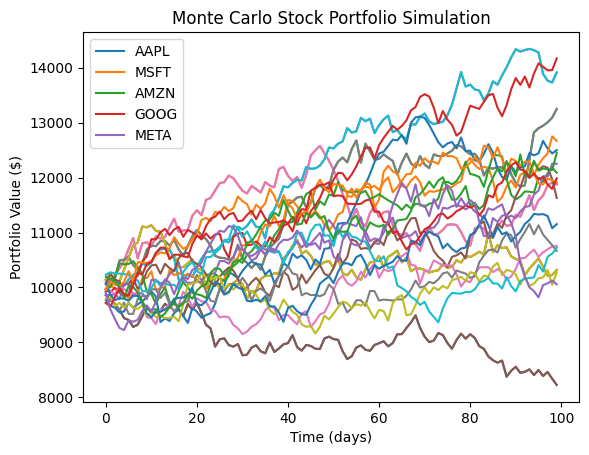

In [ ]:
num_simulation = 20 #number of simulation
T = 100 #timeframe in days

#transform mean return to day
mean_matrix = np.full(shape=(T, len(weights)), fill_value = mean_return) #shape is based on time (days) and length (how many stocks in the list)
mean_matrix = mean_matrix.T

portfolio_simulation = np.full(shape = (T, num_simulation), fill_value = 0.0) #0.0 for float format #shape is based on time (days) and number of simulation

#assume portfolio size
initial_port = 10000

for m in range(0, num_simulation): #MC loop
  #take uncorrelated sample data from norm distribution
  Z = np.random.normal(size=(T, len(weights)))
  # correlate, get correlation matrix from cholesky decomposition for lower triangular matrix
  L = np.linalg.cholesky(cov_matrix)
  daily_return = mean_matrix + np.inner(L, Z)

  #record daily return and accumulate across days -- accumulative effect of changes
  portfolio_simulation[:,m] = np.cumprod(np.inner(weights, daily_return.T)+1)*initial_port

#plot
for i in range(len(tickers)):
    plt.plot(portfolio_simulation[:, i], label=tickers[i])
plt.plot(portfolio_simulation)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Time (days)')
plt.title('Monte Carlo Stock Portfolio Simulation')
plt.legend()
plt.show()

VaR and CVAR, based on given confidence level alpha

In [ ]:
#get percentile on return distribution to a given confidence level alpha
def mcVaR(returns, alpha=5):
    if isinstance(returns, pd.Series): #take returns as input
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series of returns.")

#get CVaR (expected shortfall) to a given confidence level alpha
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series): #take returns as input
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series. Make change.")

In [ ]:
port_result = pd.Series(portfolio_simulation[-1,:])

VaR = initial_port - mcVaR(port_result, alpha=5)
CVaR = initial_port - mcCVaR(port_result, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))


VaR $33.21
CVaR $1772.88


In [ ]:
print("\nVaR:")
print(" MC VaR  95th CI: ", round(VaR,2))

print("\nCVaR:")
print(" MC CVaR 95th CI: ", round(CVaR,2))


VaR:
 MC VaR  95th CI:  33.21

CVaR:
 MC CVaR 95th CI:  1772.88
